# Loading Data

In [1]:
import numpy as np

def get_data():
    data = np.genfromtxt('data.csv', delimiter=',')
    X = data[:, 0]
    Y = data[:, 1]
    return X, Y

In [2]:
import json

def load(dataset_path):
    with open(dataset_path,"r") as f:
        data = json.load(f)
    
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])    
    
    return inputs, targets

def get_data():
    return load("data.json")

# Neural Network

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, inputs):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(inputs.shape[1] * inputs.shape[2], 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.softmax(self.fc4(x))
        return x

In [6]:
inputs, targets = get_data()

model = NeuralNetwork(inputs).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

input_train, input_test, target_train, target_test = train_test_split(inputs, targets, test_size=0.3)

train_dataset = TensorDataset(torch.tensor(input_train, dtype=torch.float32), 
                              torch.tensor(target_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(input_test, dtype=torch.float32), 
                             torch.tensor(target_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

history_nn = {"accuracy": [], "val_accuracy": [], "loss": [], "val_loss": []}
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    history_nn["loss"].append(train_loss)
    history_nn["accuracy"].append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_loss /= len(test_loader)
    val_accuracy = correct / total
    history_nn["val_loss"].append(val_loss)
    history_nn["val_accuracy"].append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch 1/50, Loss: 2.2399, Accuracy: 0.2169, Val Loss: 2.2637, Val Accuracy: 0.1946
Epoch 2/50, Loss: 2.2065, Accuracy: 0.2511, Val Loss: 2.1824, Val Accuracy: 0.2740
Epoch 3/50, Loss: 2.1789, Accuracy: 0.2768, Val Loss: 2.1525, Val Accuracy: 0.3061
Epoch 4/50, Loss: 2.1485, Accuracy: 0.3082, Val Loss: 2.1527, Val Accuracy: 0.3031
Epoch 5/50, Loss: 2.1263, Accuracy: 0.3310, Val Loss: 2.1291, Val Accuracy: 0.3271
Epoch 6/50, Loss: 2.1091, Accuracy: 0.3474, Val Loss: 2.1197, Val Accuracy: 0.3374
Epoch 7/50, Loss: 2.0904, Accuracy: 0.3687, Val Loss: 2.1215, Val Accuracy: 0.3321
Epoch 8/50, Loss: 2.0830, Accuracy: 0.3755, Val Loss: 2.0970, Val Accuracy: 0.3595
Epoch 9/50, Loss: 2.0671, Accuracy: 0.3924, Val Loss: 2.1073, Val Accuracy: 0.3508
Epoch 10/50, Loss: 2.0530, Accuracy: 0.4090, Val Loss: 2.0756, Val Accuracy: 0.3865
Epoch 11/50, Loss: 2.0157, Accuracy: 0.4443, Val Loss: 2.0637, Val Accuracy: 0.3945
Epoch 12/50, Loss: 1.9718, Accuracy: 0.4894, Val Loss: 2.0597, Val Accuracy: 0.3965
E

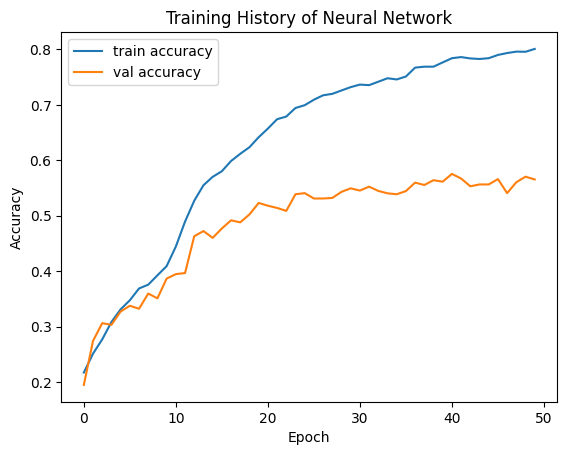

In [7]:
plt.plot(history_nn["accuracy"], label="train accuracy")
plt.plot(history_nn["val_accuracy"], label="val accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Training History of Neural Network")
plt.legend()
plt.show()

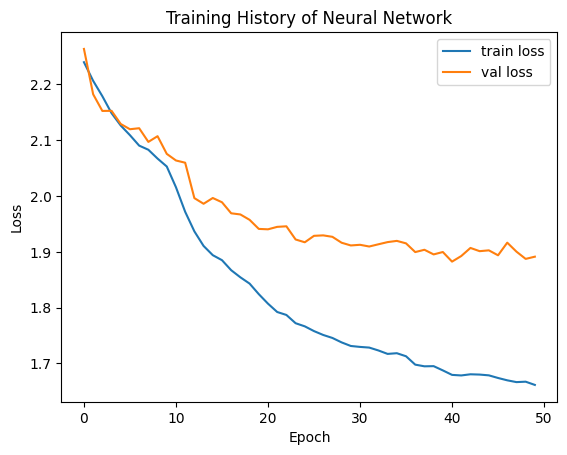

In [8]:
plt.plot(history_nn["loss"], label="train loss")
plt.plot(history_nn["val_loss"], label="val loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History of Neural Network")
plt.legend()
plt.show()

In [9]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

test_loss /= len(test_loader)
test_accuracy_nn = correct / total
print(f"Test accuracy: {test_accuracy_nn}")

Test accuracy: 0.5654205607476636


# Convolutional Neural Network

# Recurrent Neural Network